In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set style
colors = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
diverging_colors = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']

In [20]:
def process_experiment_files(base_directory):
    """
    Args:
        base_directory: Root directory containing experiment results
    """
    all_data = []
    processed_files = 0

    # Construct path to energy folder
    energy_dir = os.path.join(base_directory, 'data')
    
    # Process each CSV file in the energy directory
    for filename in os.listdir(energy_dir):
        if filename.endswith(".csv"):
            filepath = os.path.join(energy_dir, filename)
            try:
                df = pd.read_csv(filepath)
                processed_files += 1

                # Improved model name extraction
                # Example: Codestral-22B-v0.1_4bits64gs_HQQ_mns128_max-tokens256.csv
                base = filename.replace('.csv', '')
                parts = base.split('_')
                # Find the index where 'mns' or 'max-tokens' starts
                meta_idx = None
                for i, part in enumerate(parts):
                    if part.startswith('mns') or part.startswith('max-tokens'):
                        meta_idx = i
                        break
                if meta_idx is not None:
                    model_name = '_'.join(parts[:meta_idx])
                    meta_parts = parts[meta_idx:]
                else:
                    model_name = base
                    meta_parts = []
                mns_val = None
                max_tokens_val = None
                for part in meta_parts:
                    if part.startswith('mns'):
                        mns_val = int(part.replace('mns', ''))
                    if part.startswith('max-tokens'):
                        max_tokens_val = int(part.replace('max-tokens', ''))

                # Add metadata
                df["model"] = model_name
                df["mns"] = mns_val
                df["max_tokens"] = max_tokens_val

                # Compute derived metrics safely
                df["energy_per_token"] = df["gpu0_energy"] / df["num_out_tokens"].replace(0, pd.NA)
                df["time_per_token_ms"] = (df["elapsed_time"] - df['first_token_time']) / df["num_out_tokens"].replace(0, pd.NA) * 1000
                df["token_per_second"] = df["num_out_tokens"] / df["elapsed_time"].replace(0, pd.NA) 

                # Reorder columns: metadata first, then metrics
                meta_cols = ["model", "mns", "max_tokens", "window_name"]
                cols = meta_cols + [col for col in df.columns if col not in meta_cols]
                df = df[cols]

                all_data.append(df)
            except Exception as e:
                print(f"Failed to process {filename}: {e}")
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

# Plotting throughput and energy/token

In [21]:
df = process_experiment_files(os.path.curdir)
df.head(10)

,model,mns,max_tokens,window_name,start_time,elapsed_time,gpu0_energy,num_in_tokens,num_out_tokens,first_token_time,finished_time,energy_per_token,time_per_token_ms,token_per_second
0,Codestral-22B-v0.1-AWQ,128,256,humaneval,1.750686e+09,31.261682,8343.607,25342,41984,8.083811,31.257890,0.198733,0.552064,1342.985948
1,Codestral-22B-v0.1-AWQ,128,512,humaneval,1.750686e+09,55.018229,15109.059,25342,83968,8.117049,55.014246,0.179938,0.558560,1526.185062
2,Codestral-22B-v0.1-AWQ,128,1024,humaneval,1.750686e+09,110.851644,30984.404,25342,167936,8.634335,110.847687,0.184501,0.608668,1514.961747
3,Codestral-22B-v0.1,128,256,humaneval,1.750687e+09,35.241230,9421.246,25342,41984,6.251194,35.237298,0.224401,0.690502,1191.331873
4,Codestral-22B-v0.1,128,512,humaneval,1.750687e+09,65.348412,17906.746,25342,83968,6.379795,65.344384,0.213257,0.702275,1284.927928
5,Codestral-22B-v0.1,128,1024,humaneval,1.750687e+09,139.299309,39211.065,25342,167936,6.476756,139.295137,0.233488,0.790912,1205.576695
6,Codestral-22B-v0.1-GPTQ,128,256,humaneval,1.750688e+09,31.187339,8318.654,25342,41984,7.936411,31.183506,0.198139,0.553804,1346.187328
7,Codestral-22B-v0.1-GPTQ,128,512,humaneval,1.750688e+09,55.312359,14999.476,25342,83968,8.160259,55.308347,0.178633,0.561548,1518.069417
8,Codestral-22B-v0.1-GPTQ,128,1024,humaneval,1.750688e+09,110.488246,30626.689,25342,167936,8.176229,110.484223,0.182371,0.609232,1519.944487
9,Codestral-22B-v0.1_4bits64gs_HQQ,128,256,humaneval,1.750690e+09,65.573071,18684.867,25342,41984,6.316183,65.569027,0.445047,1.411416,640.262825


In [22]:
def plot_throughput_energy_per_token(model_family: str, task: str, batch_values: int = 128) -> None:
    """
    Plot energy/token and throughput for different max_tokens values for each model version.
    Args:
        model_family (str): Name of model family (e.g., 'CodeLlama-34', 'Codestral-22B')
        task (str): Task name (e.g., 'humaneval', 'codesearchnet-python')
        batch_values (int): Value for mns (batch size)
    """
    # Filter data for the specific model family, task, and batch size
    model_data = df[
        (df['model'].str.contains(model_family)) &
        (df['mns'] == batch_values)
    ]

    if model_data.empty:
        print(f"No data found for {model_family}, mns={batch_values}")
        return

    # Get unique model versions
    model_versions = model_data['model'].unique()
    max_tokens_list = sorted(model_data['max_tokens'].unique())

    # Plot for each model version
    for model_version in model_versions:
        version_data = model_data[model_data['model'] == model_version]
        if version_data.empty:
            continue

        # Aggregate by max_tokens
        agg = version_data.groupby('max_tokens').agg({
            'energy_per_token': 'median',
            'token_per_second': 'median'
        }).reindex(max_tokens_list)

        fig, ax1 = plt.subplots(figsize=(6, 4))
        ax2 = ax1.twinx()

        # Bar plot for energy per token
        bars = ax1.bar(agg.index.astype(str), agg['energy_per_token'], color=diverging_colors[-1], alpha=0.7, label='Energy/Token (J)')
        ax1.set_ylabel('Energy/Token (J)', color=diverging_colors[-1])
        ax1.tick_params(axis='y', labelcolor=diverging_colors[-1])

        # Line plot for throughput
        line = ax2.plot(agg.index.astype(str), agg['token_per_second'], color=diverging_colors[0], marker='o', linewidth=2, label='Throughput')
        ax2.set_ylabel('Tokens/Second', color=diverging_colors[0])
        ax2.tick_params(axis='y', labelcolor=diverging_colors[0])

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        for i, v in enumerate(agg['token_per_second']):
            ax2.text(i, v, f'{v:.1f}', ha='center', va='bottom')

        plt.title(f"{model_version} on (mns={batch_values})")
        plt.xlabel('max_tokens')
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_throughput_energy_vs_max_tokens('Codestral-22B', 'humaneval', batch_values=128)

In [ ]:
def plot_throughput_energy_gpu(model_family: str, task: str, batch_values: int = 128) -> None:
    """
    Plot energy/token and throughput for different max_tokens values for each model version.
    Args:
        model_family (str): Name of model family (e.g., 'CodeLlama-34', 'Codestral-22B')
        task (str): Task name (e.g., 'humaneval', 'codesearchnet-python')
        batch_values (int): Value for mns (batch size)
    """
    # Filter data for the specific model family, task, and batch size
    model_data = df[
        (df['model'].str.contains(model_family)) &
        (df['mns'] == batch_values)
    ]

    if model_data.empty:
        print(f"No data found for {model_family}, mns={batch_values}")
        return

    # Get unique model versions
    model_versions = model_data['model'].unique()
    max_tokens_list = sorted(model_data['max_tokens'].unique())

    # Plot for each model version
    for model_version in model_versions:
        version_data = model_data[model_data['model'] == model_version]
        if version_data.empty:
            continue

        # Aggregate by max_tokens
        agg = version_data.groupby('max_tokens').agg({
            'gpu0_energy': 'median',
            'token_per_second': 'median'
        }).reindex(max_tokens_list)

        fig, ax1 = plt.subplots(figsize=(6, 4))
        ax2 = ax1.twinx()

        # Bar plot for energy per token
        bars = ax1.bar(agg.index.astype(str), agg['gpu0_energy'] / 1000, color=diverging_colors[-1], alpha=0.7, label='Energy (kJ)')
        ax1.set_ylabel('Energy (kJ)', color=diverging_colors[-1])
        ax1.tick_params(axis='y', labelcolor=diverging_colors[-1])

        # Line plot for throughput
        line = ax2.plot(agg.index.astype(str), agg['token_per_second'], color=diverging_colors[0], marker='o', linewidth=2, label='Throughput')
        ax2.set_ylabel('Tokens/Second', color=diverging_colors[0])
        ax2.tick_params(axis='y', labelcolor=diverging_colors[0])
        ax2.set_yticks(np.arange(0, 2100, 200))

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        for i, v in enumerate(agg['token_per_second']):
            ax2.text(i, v, f'{v:.1f}', ha='center', va='bottom')

        plt.title(f"{model_version} on (mns={batch_values})")
        plt.xlabel('max_tokens')
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_throughput_energy_vs_max_tokens('Codestral-22B', 'humaneval', batch_values=128)

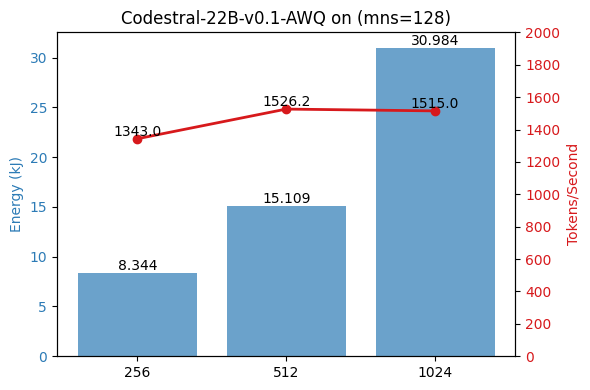

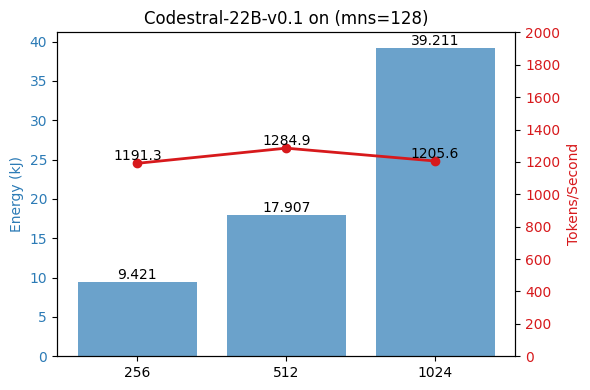

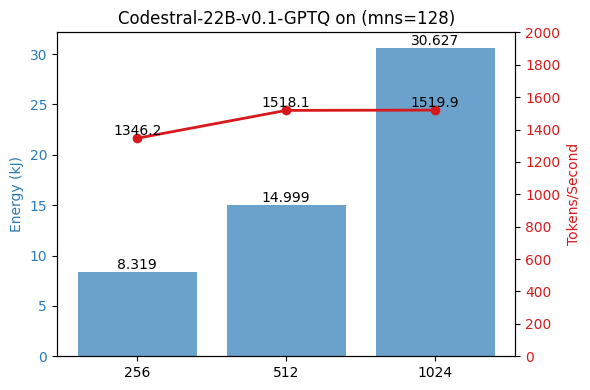

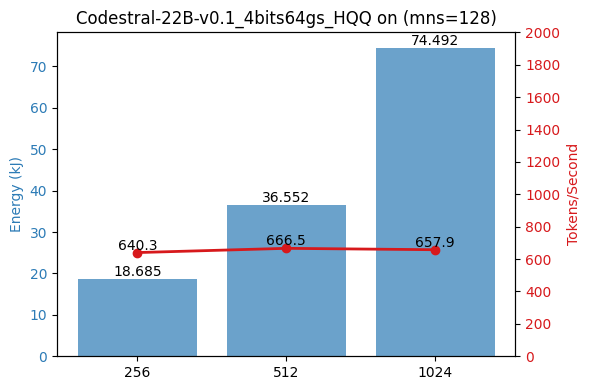

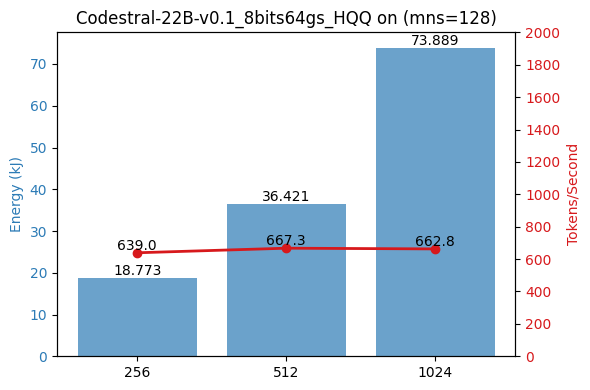

In [24]:
plot_throughput_energy_gpu('Codestral-22B', 'humaneval')

In [35]:
def plot_tpt_energy(model_family: str, task: str, batch_values: int = 128) -> None:
    """
    Plot energy/token and throughput for different max_tokens values for each model version.
    Args:
        model_family (str): Name of model family (e.g., 'CodeLlama-34', 'Codestral-22B')
        task (str): Task name (e.g., 'humaneval', 'codesearchnet-python')
        batch_values (int): Value for mns (batch size)
    """
    # Filter data for the specific model family, task, and batch size
    model_data = df[
        (df['model'].str.contains(model_family)) &
        (df['mns'] == batch_values)
    ]

    if model_data.empty:
        print(f"No data found for {model_family}, mns={batch_values}")
        return

    # Get unique model versions
    model_versions = model_data['model'].unique()
    max_tokens_list = sorted(model_data['max_tokens'].unique())

    # Plot for each model version
    for model_version in model_versions:
        version_data = model_data[model_data['model'] == model_version]
        if version_data.empty:
            continue

        # Aggregate by max_tokens
        agg = version_data.groupby('max_tokens').agg({
            'time_per_token_ms': 'median',
            'first_token_time': 'median'
        }).reindex(max_tokens_list)

        fig, ax1 = plt.subplots(figsize=(6, 4))
        ax2 = ax1.twinx()

        # Bar plot for energy per token
        bars = ax1.bar(agg.index.astype(str), agg['time_per_token_ms'], color=diverging_colors[-1], alpha=0.7, label='Time-per-token (ms)')
        ax1.set_ylabel('Time-per-token (ms)', color=diverging_colors[-1])
        ax1.tick_params(axis='y', labelcolor=diverging_colors[-1])

        # Line plot for throughput
        line = ax2.plot(agg.index.astype(str), agg['first_token_time'], color=diverging_colors[0], marker='o', linewidth=2, label='First token time (s)')
        ax2.set_ylabel('First token time (s)', color=diverging_colors[0])
        ax2.tick_params(axis='y', labelcolor=diverging_colors[0])
        ax2.set_yticks(np.arange(0, 20, 2))

        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        for i, v in enumerate(agg['first_token_time']):
            ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom')

        plt.title(f"{model_version} on {task} (mns={batch_values})")
        plt.xlabel('max_tokens')
        plt.tight_layout()
        plt.show()

# Example usage:
# plot_throughput_energy_vs_max_tokens('Codestral-22B', 'humaneval', batch_values=128)

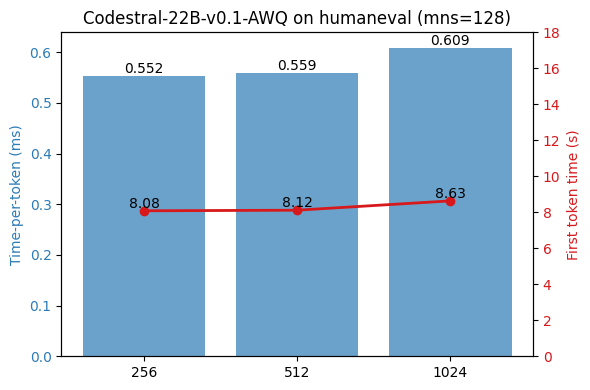

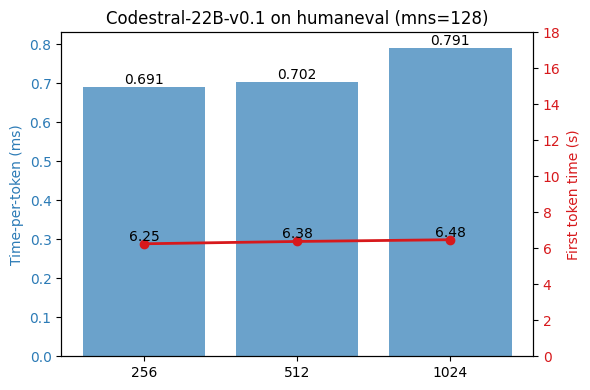

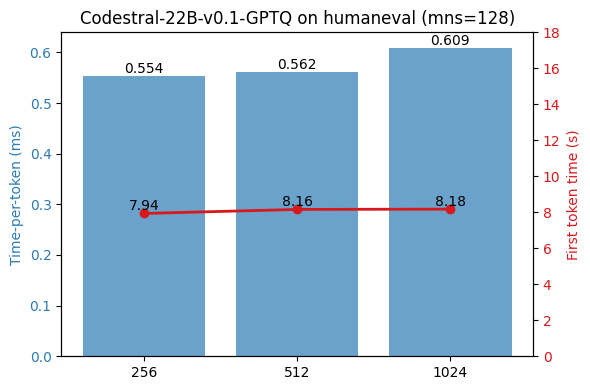

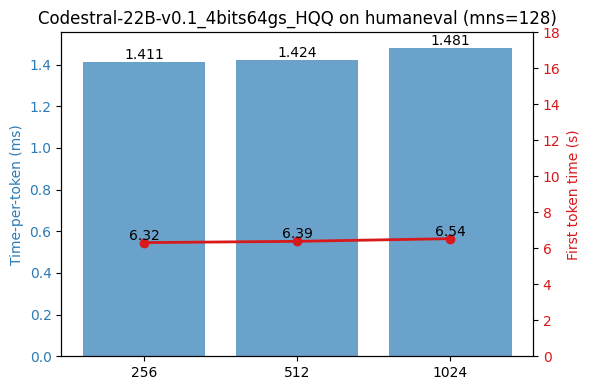

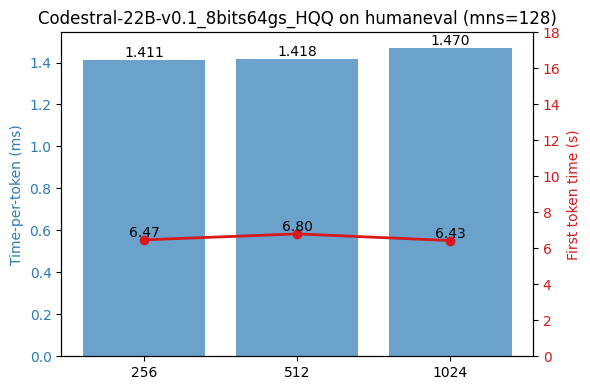

In [36]:
plot_tpt_energy('Codestral-22B', 'humaneval')